In [ ]:
# INSTALL PACKAGES
%pip install contextily # to give background
%pip install geopandas
%pip install shapely
!apt install python3-rtree 

import geopandas
import contextily 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.parser import parse
from datetime import datetime


from shapely.geometry import Point


# import data from google drive
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
delitos = geopandas.read_file('/content/drive/My Drive/delitos_pgj_completo.csv')
alcaldias = geopandas.read_file('/content/drive/My Drive/limite-de-las-alcaldias.geojson')
colonias = geopandas.read_file('/content/drive/My Drive/coloniascdmx.geojson')

##Procesamiento de los datos

In [ ]:
delitos.head(2)

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalia,agencia,unidad_investigacion,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,calle_hechos,calle_hechos2,longitud,latitud,geopoint,geometry
0,2017,Febrero,2017-02-01 14:00:00,LA ADMINISTRACION DE JUSTICIA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN DE LOS DELITOS COMETIDOS POR SER...,B,UI-1CD,MIGUEL HIDALGO,AMPLIACIÓN DANIEL GARZA,2017,Febrero,2017-02-01 19:24:54,PARQUE LIRA,NA,-99.1906199939041,19.4077917274833,"19.4077917275,-99.1906199939",None
1,2017,Enero,2017-01-08 01:33:00,ROBO A NEGOCIO SIN VIOLENCIA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN IZTAPALAPA,IZP-4,UI-1SD,IZTAPALAPA,SAN MIGUEL,2017,Febrero,2017-02-01 19:27:02,LUIS HIDALGO MONROY,NA,-99.077566999491,19.3552146512287,"19.3552146512,-99.0775669995",None


In [ ]:
delitos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1081451 entries, 0 to 1081450
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   ao_hechos             1081451 non-null  object  
 1   mes_hechos            1081451 non-null  object  
 2   fecha_hechos          1081451 non-null  object  
 3   delito                1081451 non-null  object  
 4   categoria_delito      1081451 non-null  object  
 5   fiscalia              1081451 non-null  object  
 6   agencia               1081451 non-null  object  
 7   unidad_investigacion  1081451 non-null  object  
 8   alcaldia_hechos       1081451 non-null  object  
 9   colonia_hechos        1081451 non-null  object  
 10  ao_inicio             1081451 non-null  object  
 11  mes_inicio            1081451 non-null  object  
 12  fecha_inicio          1081451 non-null  object  
 13  calle_hechos          1081451 non-null  object  
 14  calle_hech

In [ ]:
# dropeamos columnas
prueba = delitos.copy()
col_drop = ['fiscalia','agencia','unidad_investigacion','calle_hechos','calle_hechos2','geometry']
prueba = prueba.drop(col_drop, axis=1)

### Datos repetidos
Se checo y no se repite ninguna observacion, por lo que pasaremos a dropear las columnas que no son necesarias para el desarrollo del proyecto.

In [ ]:
len(prueba[prueba.duplicated(keep=False)])

0

## Datos faltantes

Por categorias vamos a ver los datos faltantes y a eliminarlos en caso de que no representen más del 10% de la base , ya que es un porcentaje que no va a llegar a afectar los resultados.

* Tiempo = 0.038% (413)
* Ubicación = 3.99% (42791)


In [ ]:
# Notar como estan definidos los na's
def null(df):
  null_cols = df.isnull().sum()
  print(null_cols[null_cols>0])

print(null(prueba))
print(prueba['ao_hechos'].unique())
print(prueba['mes_hechos'].unique())

Series([], dtype: int64)
None
['2017' '2016' '2015' '2013' '2006' '2009' '2012' '2014' '2011' '2004'
 '2010' '1983' '2002' '1998' '2007' '2001' '1997' '2008' '2000' '1994'
 '1999' '2005' '1989' '2003' 'NA' '1993' '1966' '1976' '1992' '2018'
 '1984' '1981' '1990' '1969' '1995' '1982' '1996' '1986' '1970' '1980'
 '1974' '1972' '1955' '1978' '1985' '1988' '2020' '2019' '1987' '1991'
 '1964' '1963' '1975' '1971' '1956' '1968' '1950' '1957' '1979' '1954'
 '1915' '1965' '1977' '1973' '1942' '1960' '1930' '1906' '1962' '1958']
['Febrero' 'Enero' 'Diciembre' 'Julio' 'Junio' 'Septiembre' 'Octubre'
 'Noviembre' 'Agosto' 'Abril' 'Mayo' 'Marzo' 'NA']


In [ ]:
prueba = prueba.replace('NA', np.nan)
print(null(prueba))

ao_hechos            413
mes_hechos           413
fecha_hechos         160
alcaldia_hechos      812
colonia_hechos     34787
longitud           42872
latitud            42872
dtype: int64
None


In [ ]:
# Tiempo
# Se verifican los datos para la primera categoria
p1 = prueba['ao_hechos'].isnull()
#p2 = prueba['fecha_hechos']!='NA'
prueba[p1]

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,longitud,latitud,geopoint
21158,NaN,NaN,NaN,ABUSO DE AUTORIDAD,DELITO DE BAJO IMPACTO,IZTAPALAPA,SANTA MARTHA ACATITLA,2016,Marzo,2016-03-06 15:37:54,-99.012012,19.3617329998336,"19.3617329998,-99.012012"
21446,NaN,NaN,NaN,ROBO A TRANSEUNTE EN NEGOCIO CON VIOLENCIA,DELITO DE BAJO IMPACTO,GUSTAVO A MADERO,LINDAVISTA,2016,Marzo,2016-03-07 22:57:38,-99.1353939999999,19.4933249998335,"19.4933249998,-99.135394"
21618,NaN,NaN,NaN,ROBO DE VEHICULO DE SERVICIO PÚBLICO SIN VIOLE...,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,IZTAPALAPA,JOSÉ LÓPEZ PORTILLO,2016,Marzo,2016-03-08 19:26:54,-99.0816419999999,19.3047409998341,"19.3047409998,-99.081642"
21878,NaN,NaN,NaN,ABUSO DE CONFIANZA,DELITO DE BAJO IMPACTO,MIGUEL HIDALGO,POLANCO,2016,Marzo,2016-03-10 11:06:45,-99.1889139999999,19.4304149998337,"19.4304149998,-99.188914"
21957,NaN,NaN,NaN,FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...,DELITO DE BAJO IMPACTO,VENUSTIANO CARRANZA,AERONÁUTICA MILITAR,2016,Marzo,2016-03-10 16:43:51,-99.1160659999999,19.4250669998333,"19.4250669998,-99.116066"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
997647,NaN,NaN,NaN,ROBO DE OBJETOS,DELITO DE BAJO IMPACTO,CUAUHTEMOC,SANTA MARIA LA RIBERA,2016,Mayo,2016-05-08 00:02:56,-99.1554539999999,19.4534029998336,"19.4534029998,-99.155454"
999263,NaN,NaN,NaN,ROBO A NEGOCIO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,MIGUEL HIDALGO,LOMAS DE CHAPULTEPEC I SECCIÓN,2016,Mayo,2016-05-17 14:26:19,-99.2228189999999,19.4263419998333,"19.4263419998,-99.222819"
1064859,NaN,NaN,NA NA,NARCOMENUDEO POSESION SIMPLE,DELITO DE BAJO IMPACTO,MIGUEL HIDALGO,,2018,Febrero,2018-02-17 00:27,NaN,NaN,
1072811,NaN,NaN,NA NA,ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA,DELITO DE BAJO IMPACTO,IZTACALCO,,2018,Julio,2018-07-20 18:55,NaN,NaN,


In [ ]:
# Dropeamos los datos faltantes
prueba = prueba.replace('NA NA', np.nan)
prueba = prueba.dropna(subset=['ao_hechos','mes_hechos','fecha_hechos'])

# Cambiamos el formato de la fecha
prueba['fecha_hechos'] = list(map((lambda x : parse(x[0:10])),prueba['fecha_hechos']))

In [ ]:
# Ubicación
# Volvemos las alcaldias a minuscula y hacemos un empate con la base de delitos
# para que sólo nos queden las observaciones del cdmx
a,b = 'áéíóúüñÁÉÍÓÚÜÑ','aeiouunAEIOUUN'
trans = str.maketrans(a,b)

low_tilde = lambda x:x.translate(trans).lower().replace('.','')
alcaldias['nomgeo'] = list(map(low_tilde,alcaldias['nomgeo']))
prueba['alcaldia_hechos']=prueba['alcaldia_hechos'].str.lower()

cdmx = prueba.loc[prueba['alcaldia_hechos'].isin(alcaldias['nomgeo'])]
n_cdmx=len(cdmx)
n_cdmx

1069840

In [ ]:
cdmx.groupby('alcaldia_hechos')['delito'].count()

alcaldia_hechos
alvaro obregon             72373
azcapotzalco               52263
benito juarez              91451
coyoacan                   72001
cuajimalpa de morelos      15629
cuauhtemoc                170873
gustavo a madero          108050
iztacalco                  45166
iztapalapa                162414
la magdalena contreras     16934
miguel hidalgo             70899
milpa alta                  7260
tlahuac                    25582
tlalpan                    63052
venustiano carranza        62419
xochimilco                 33474
Name: delito, dtype: int64

In [ ]:
null(cdmx)

colonia_hechos    25832
longitud          31599
latitud           31599
dtype: int64


In [ ]:
# Quitamos los datos faltantes de latitud y longitud
cdmx_prueba = cdmx.dropna(subset=['latitud','longitud'])
print(len(cdmx_prueba))
print(cdmx_prueba.info())

1038241
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1038241 entries, 0 to 1081450
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   ao_hechos         1038241 non-null  object        
 1   mes_hechos        1038241 non-null  object        
 2   fecha_hechos      1038241 non-null  datetime64[ns]
 3   delito            1038241 non-null  object        
 4   categoria_delito  1038241 non-null  object        
 5   alcaldia_hechos   1038241 non-null  object        
 6   colonia_hechos    1037261 non-null  object        
 7   ao_inicio         1038241 non-null  object        
 8   mes_inicio        1038241 non-null  object        
 9   fecha_inicio      1038241 non-null  object        
 10  longitud          1038241 non-null  object        
 11  latitud           1038241 non-null  object        
 12  geopoint          1038241 non-null  object        
dtypes: datetime64[ns](1), obje

In [ ]:
# Convertimos la longitud y latitud a float y el año de los hechos a entero
cdmx_prueba["longitud"] = pd.to_numeric(cdmx_prueba["longitud"], downcast="float")
cdmx_prueba["latitud"] = pd.to_numeric(cdmx_prueba["latitud"], downcast="float")
cdmx_prueba["ao_hechos"] = pd.to_numeric(cdmx_prueba["ao_hechos"], downcast="float").astype(int)

Nos tomaremos del año 2009 al 2020 para hacer el análisis de los delitos de la CDMX, ya que como se puede ver en la gráfica de abajo no se tienen registro suficientes por año, lo que sesgaría el análisis.

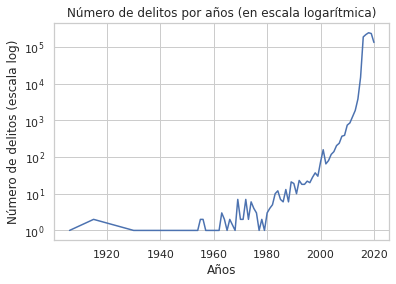

In [ ]:
path = cdmx_prueba['ao_hechos'].value_counts()
years = path.sort_index()

sns.set_theme(style="white")
years.plot()
plt.yscale('log')
plt.xlabel('Años')
plt.ylabel('Número de delitos (escala log)')
plt.title('Número de delitos por años (en escala logarítmica)')
plt.show()

In [ ]:
cdmx_new = cdmx_prueba[cdmx_prueba['ao_hechos']>=2009]
cdmx_new.reset_index(drop=True)

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,longitud,latitud,geopoint
0,2017,Febrero,2017-02-01,LA ADMINISTRACION DE JUSTICIA,DELITO DE BAJO IMPACTO,miguel hidalgo,AMPLIACIÓN DANIEL GARZA,2017,Febrero,2017-02-01 19:24:54,-99.190620,19.407791,"19.4077917275,-99.1906199939"
1,2017,Enero,2017-01-08,ROBO A NEGOCIO SIN VIOLENCIA,DELITO DE BAJO IMPACTO,iztapalapa,SAN MIGUEL,2017,Febrero,2017-02-01 19:27:02,-99.077568,19.355215,"19.3552146512,-99.0775669995"
2,2017,Enero,2017-01-31,ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO,DELITO DE BAJO IMPACTO,iztapalapa,SAN ANTONIO CULHUACÁN,2017,Febrero,2017-02-01 19:42:25,-99.112732,19.340765,"19.3407640843,-99.1127351614"
3,2017,Enero,2017-01-30,AMENAZAS,DELITO DE BAJO IMPACTO,cuauhtemoc,ATLAMPA,2017,Febrero,2017-02-01 19:45:49,-99.156921,19.458632,"19.4586324098,-99.1569182596"
4,2016,Diciembre,2016-12-13,ROBO DE OBJETOS,DELITO DE BAJO IMPACTO,coyoacan,PRADO CHURUBUSCO,2017,Febrero,2017-02-01 19:46:26,-99.128242,19.358326,"19.3583260659,-99.128243693"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036418,2016,Junio,2016-06-23,FRAUDE,DELITO DE BAJO IMPACTO,miguel hidalgo,LOMAS DE BEZARES,2017,Agosto,2017-08-31 22:37:44,-99.248047,19.387857,"19.387857459,-99.2480472885"
1036419,2017,Agosto,2017-08-17,ROBO A REPARTIDOR CON VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,iztapalapa,MIXCOATL,2017,Agosto,2017-08-31 22:39:47,-99.049698,19.325979,"19.3259788728,-99.0496987887"
1036420,2017,Agosto,2017-08-31,ROBO DE VEHICULO DE SERVICIO PÚBLICO SIN VIOLE...,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,cuauhtemoc,PERALVILLO,2017,Agosto,2017-08-31 23:44:16,-99.135719,19.462185,"19.4621852862,-99.1357158364"
1036421,2017,Agosto,2017-08-01,ROBO A NEGOCIO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,gustavo a madero,PROGRESO NACIONAL,2017,Agosto,2017-08-31 23:55:50,-99.160988,19.518373,"19.5183739393,-99.1609915817"


Análsis y resolución de la prueba.

3. Distribución de los delitos en CDMX
 * 5 delitos más frecuentes


 Los delitos se concentran principalmente en la zona centro de la ciudad con la delegación Cuahtemoc liderando con casi el 16%, de aquí le sigue la delegación iztapalapa. La delegación con menos delitos reportados es Milpa Alta con el 0.7% de los registros.
 Los delitos más frecuentes son los siguientes.


>Delito                                         |   Frecuencia |
>--- | ---
>VIOLENCIA FAMILIAR                             |             101526 |
>ROBO A NEGOCIO SIN VIOLENCIA                   |              64581 |
>ROBO DE OBJETOS                                |              64320 |
>FRAUDE                                         |              61245 |
>ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA |              54722 |


[]

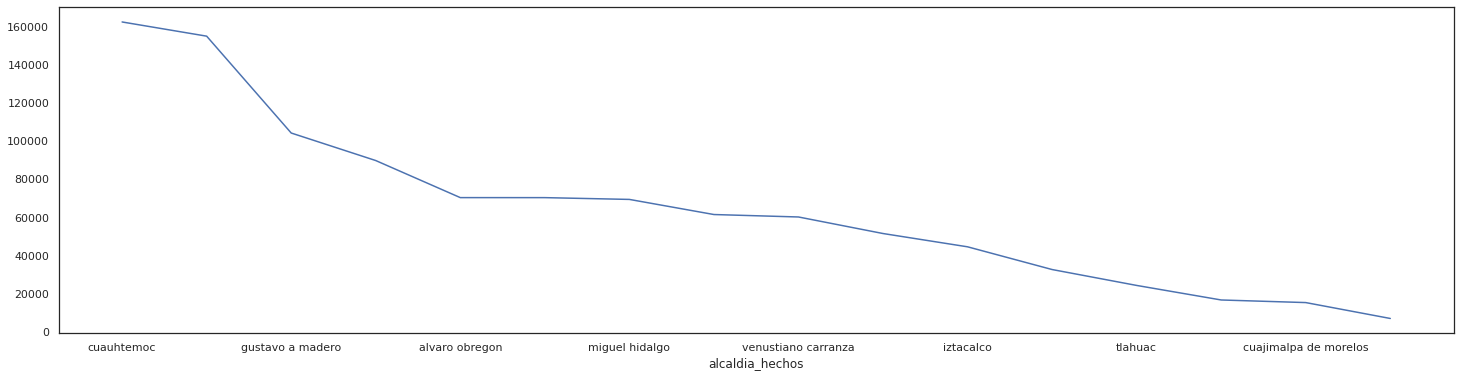

In [ ]:
dist_del = cdmx_new.groupby('alcaldia_hechos')['delito'].count().sort_values(ascending=False)

dist_del.plot(figsize=(25,6))
plt.plot()

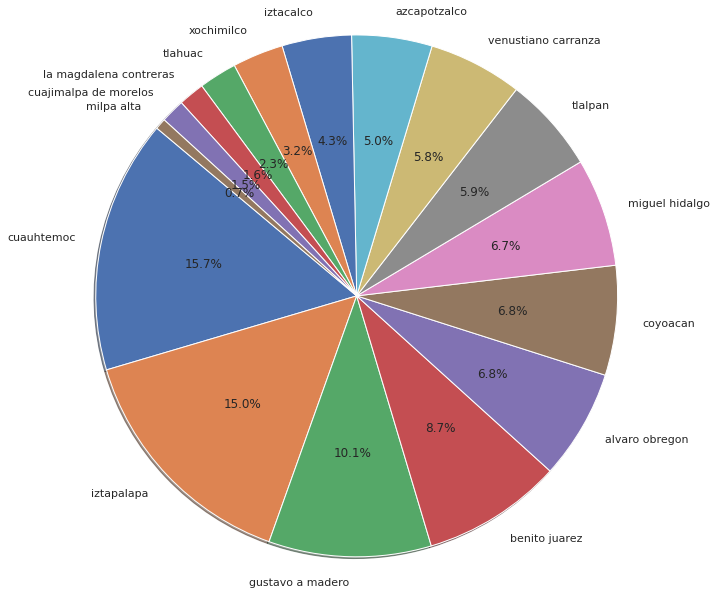

In [ ]:
df = dist_del.to_frame()
names = df.index
df['porcentaje'] = df['delito']/len(cdmx_new)*100

plt.pie(df['porcentaje'],labels=names,radius=3, autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [ ]:
# Creamos un geodataframe
# Mexico EPSG:6372 con transformacion: 6373
geometry = [Point(xy) for xy in zip(cdmx_new["longitud"], cdmx_new["latitud"])]
cdmx_geo = cdmx_new.drop(['longitud', 'latitud'], axis=1)
gdf = geopandas.GeoDataFrame(cdmx_geo, crs="EPSG:6372", geometry=geometry)

In [ ]:
alcaldias = alcaldias[['nomgeo','geometry']].sort_values('nomgeo').reset_index(drop=True)

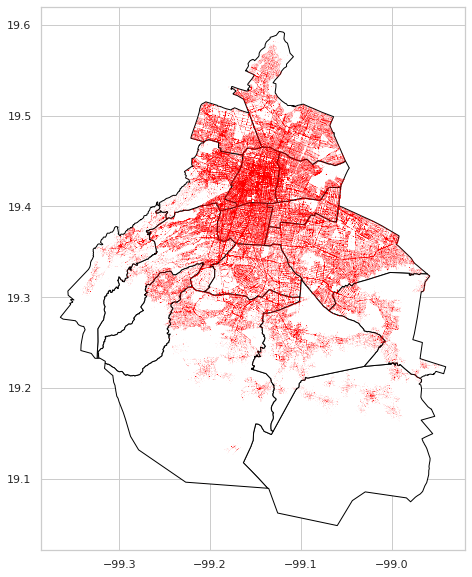

In [ ]:
# geoplot de puntos 
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_aspect('equal')
alcaldias.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax,color='red',markersize=0.01,alpha=0.1)
plt.show()

In [ ]:
from shapely.geometry import polygon
import shapely.wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable

alcaldia_delito = gdf.groupby('alcaldia_hechos')['delito'].count().reset_index()
alcaldia_delito['geometry']=alcaldias['geometry']
alcal_geo = geopandas.GeoDataFrame(alcaldia_delito)

[]

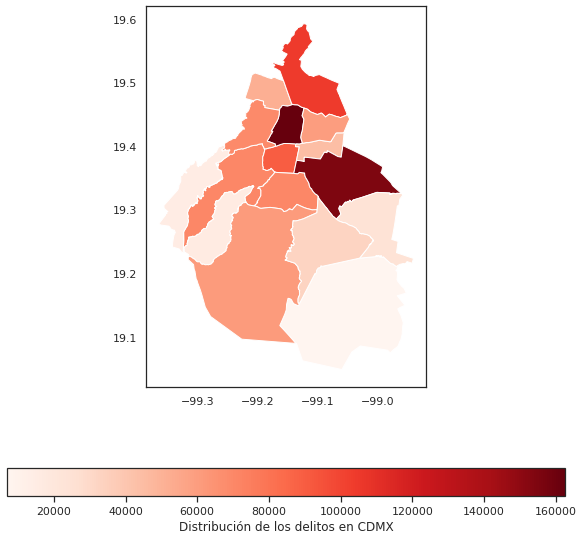

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
alcal_geo.plot(column='delito', cmap='Reds',ax = ax, legend = True, legend_kwds={'label':'Distribución de los delitos en CDMX', 'orientation':'horizontal'})
plt.plot()

In [ ]:
# 5 delitos mas frecuentes
max_delitos = gdf.groupby('delito')['categoria_delito'].count().sort_values(ascending = False).reset_index()
m_d = max_delitos['delito'][0:5]
max_delitos.head(5)
#print(max_delitos.head(5).to_markdown(tablefmt="grid"))

+----+------------------------------------------------+--------------------+
|    | delito                                         |   categoria_delito |
+====+================================================+====================+
|  0 | VIOLENCIA FAMILIAR                             |             101526 |
+----+------------------------------------------------+--------------------+
|  1 | ROBO A NEGOCIO SIN VIOLENCIA                   |              64581 |
+----+------------------------------------------------+--------------------+
|  2 | ROBO DE OBJETOS                                |              64320 |
+----+------------------------------------------------+--------------------+
|  3 | FRAUDE                                         |              61245 |
+----+------------------------------------------------+--------------------+
|  4 | ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA |              54722 |
+----+------------------------------------------------+--------------------+

4. Delitos a la alza en CDMX en el ultimo año.

Para poder calcular los delitos a la alza, primero tomamos los datos de septiembre del 2019 a septiembre del 2020. Al haber delitos con una frecuencia muy baja decidimos poner criterios y dejar sólo los delitos que hubieran ocurrido en todas las delegaciones, sin embargo todavía se encontraban delitos que tenían muy poca frecuencia por lo que se estipulo sólo dejar los que estuvierán por arriba del 10% de ocurrencias.
Nos quedamos con sólo 19 delitos:

|    | Delito                                                                                                                                           | Tendencia|
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------|:----------:|
|  0 | LESIONES INTENCIONALES POR GOLPES                                                                                                                    |Alza|
|  1 | ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VIOLENCIA                                                                                                |Alza|
|  2 | ABUSO SEXUAL                                                                                                                                         |Alza|
|  3 | ABUSO DE CONFIANZA                                                                                                                                   |Alza|
|  4 | DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO VEHICULAR A AUTOMOVIL                                                                                   |Alza|
|  5 | DESPOJO                                                                                                                                              |Alza|
|  6 | PRODUCCIÓN, IMPRESIÓN, ENAJENACIÓN, DISTRIBUCIÓN, ALTERACIÓN O FALSIFICACIÓN DE TÍTULOS AL PORTADOR, DOCUMENTOS DE CRÉDITO PÚBLICOS O VALES DE CANJE |Alza|
|  7 | ROBO A NEGOCIO SIN VIOLENCIA POR FARDEROS (TIENDAS DE AUTOSERVICIO)                                                                                  |Alza|
|  8 | ROBO A CASA HABITACION SIN VIOLENCIA                                                                                                                 |Alza|
|  9 | NARCOMENUDEO POSESION SIMPLE                                                                                                                         |Alza|
| 10 | ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO                                                                                                          |Alza|
| 11 | ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA                                                                                                |Alza|
| 12 | ROBO DE ACCESORIOS DE AUTO                                                                                                                           |Alza|
| 13 | ROBO A NEGOCIO SIN VIOLENCIA                                                                                                                         |Alza|
| 14 | ROBO DE OBJETOS                                                                                                                                      |Alza|
| 15 | ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA                                                                                                       |Alza|
| 16 | FRAUDE                                                                                                                                               |Alza|
| 17 | AMENAZAS                                                                                                                                             |Alza|
| 18 | VIOLENCIA FAMILIAR                                                                                                                                   |Alza|

In [ ]:
# Dejamos solo las observaciones despues de septiembre del 2019
d = cdmx_new['fecha_hechos']>datetime(2019,9,1)
cdmx_2019 = cdmx_new[d1].reset_index(drop=True) 

# Creamos un indice que nos muestre los delitos que hayan ocurrido dentro de todas las delegaciones
y = cdmx_2019.groupby(['delito','alcaldia_hechos',])['categoria_delito'].count().reset_index()['delito'].value_counts()
filtro = y[y==16].index

# Filtramos la base para solo dejar esos delitos
f2 = cdmx_2019['delito'].isin(filtro)
a = cdmx_2019[f2].groupby(['delito'])['categoria_delito'].count().reset_index().sort_values('categoria_delito')

# Al haber muy pocas ocurrencias se dejo sólo los que cumplieran el 10% del total de los crimenes.
n = a['categoria_delito'].sum()
a['porcentaje'] = a['categoria_delito']/n*100
f3 = a['porcentaje']>=1.4
delitos_10 = a[f3].reset_index(drop=True)['delito'] # 19 delitos

cdmx_2019_10 = cdmx_2019[cdmx_2019['delito'].isin(delitos_10)]

In [ ]:
print(delitos_10.to_markdown())

|    | delito                                                                                                                                               |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | LESIONES INTENCIONALES POR GOLPES                                                                                                                    |
|  1 | ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VIOLENCIA                                                                                                |
|  2 | ABUSO SEXUAL                                                                                                                                         |
|  3 | ABUSO DE CONFIANZA                                                                                                                                   |
|  4 | DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO 

In [ ]:
import statsmodels.api as sm

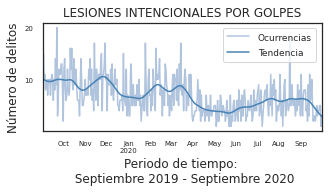

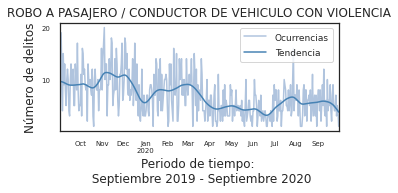

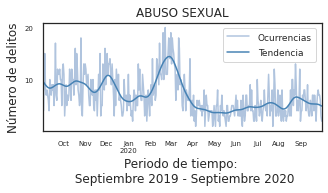

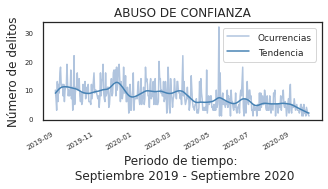

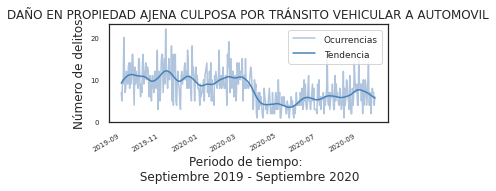

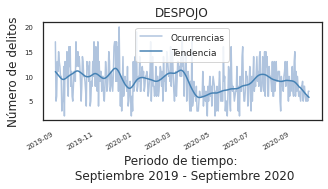

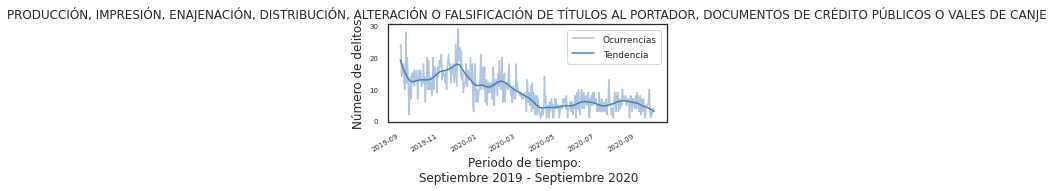

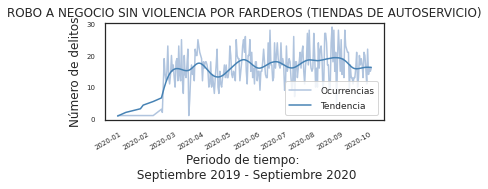

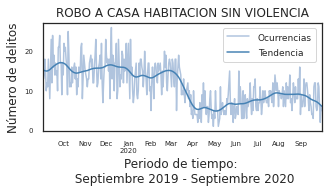

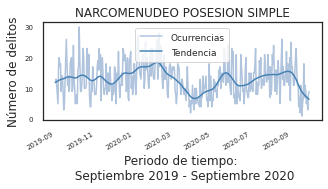

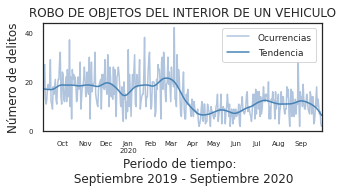

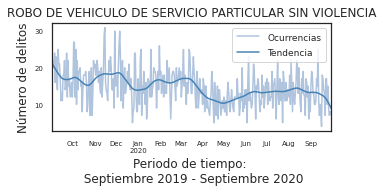

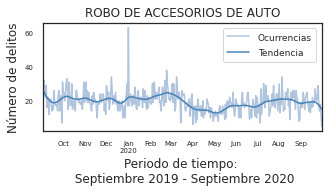

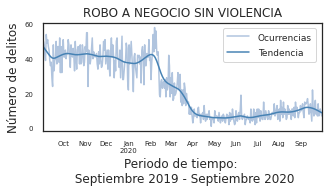

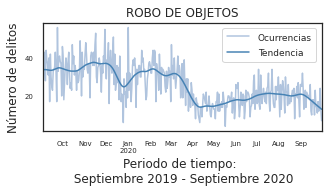

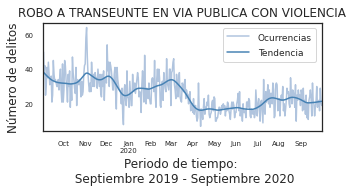

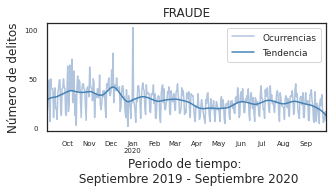

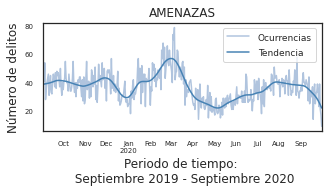

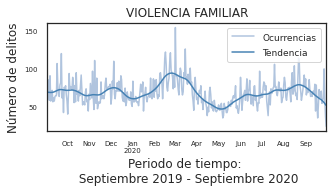

In [ ]:
def trend():

  for i in delitos_10:
    ser = cdmx_2019_10[cdmx_2019_10['delito']==i].groupby('fecha_hechos')['delito'].count().to_frame()
    cycle, trend = sm.tsa.filters.hpfilter(ser.delito, 1000) # Hodrick-Prescott para datos diarios 1000-10^8
    ser['trend'] = trend

  # Plot
    ser[['delito', 'trend']].plot(figsize=(5, 2), fontsize=7, color = ['lightsteelblue','steelblue'])
    plt.xlabel('Periodo de tiempo: \n Septiembre 2019 - Septiembre 2020')
    plt.ylabel('Número de delitos')
    plt.title(i)
    legend = plt.legend(labels=['Ocurrencias', 'Tendencia'])
    legend.prop.set_size(9)
    plt.show()

trend()

5. ¿Cuál es la alcaldia que tiene mas delitos y cual menos? ¿por que crees eso?

Como ya se mencionó, Cuahtemoc es la alcaldía que tiene la mayor frecuencia de delitos, se puede suponer que es por que tambíen tiene una alta densidad poblacional, al igual que Iztapalapa. También puede llegar a influir que Cuahtemoc es una de las zonas donde hay una alta desigualdad entre colonias y donde se concentra la mayor afluencia de gente en el transporte público. En Iztapalapa puede influir tambíen que ahí se encuentran el mayor número de grupos delictivos.
 
 Por otro lado Milpa es la que tiene una menor frecuencia y se puede pensar que es por existe una gran densidad poblacional. Aparte según la SEDECO, Milpa Alta es la delegación que tiene un mayor porcentaje de personas que ganan entre 1 y un poco más de 2 salarios mínimos, siendo un blanco no muy interesante para los delicuentes.

In [ ]:
cdmx_new['alcaldia_hechos'].value_counts()

cuauhtemoc                162609
iztapalapa                155160
gustavo a madero          104333
benito juarez              89883
alvaro obregon             70431
coyoacan                   70420
miguel hidalgo             69483
tlalpan                    61553
venustiano carranza        60267
azcapotzalco               51585
iztacalco                  44610
xochimilco                 32687
tlahuac                    24343
la magdalena contreras     16709
cuajimalpa de morelos      15346
milpa alta                  7004
Name: alcaldia_hechos, dtype: int64

6. Dentro de cada alcaldia, ¿cuales son las tres colonias con mas delitos?

In [ ]:
def colonias_delictivas(n_colonias,tipo): # tipo : 'mayor', 'menor'
  '''Devulve el número(n_colonias) del colonias con mayor/menor
     frecuencia de delitos registrados de todas las delegaciones'''
  l = []

  if tipo == 'mayor':
    asc = False
  elif tipo == 'menor':
    asc = True

  for i in alcaldias['nomgeo']:
    l.append(alca_col[alca_col['alcaldia_hechos']==i].sort_values('delito',ascending=asc).head(n_colonias))
  
  df = pd.concat(l).set_index('alcaldia_hechos')
  return df

colonias_delictivas(3,'mayor')

,colonia_hechos,delito
alcaldia_hechos,,
alvaro obregon,JARDINES DEL PEDREGAL,3269
alvaro obregon,SAN ANGEL,2626
alvaro obregon,ZEDEC SANTA FE,2501
azcapotzalco,EL ROSARIO,3736
azcapotzalco,INDUSTRIAL VALLEJO,2464
azcapotzalco,CENTRO DE AZCAPOTZALCO,2278
benito juarez,DEL VALLE CENTRO,16092
benito juarez,NARVARTE,11744
benito juarez,PORTALES SUR,5968


7. Tendencia estacional en la ocurrencia de delitos

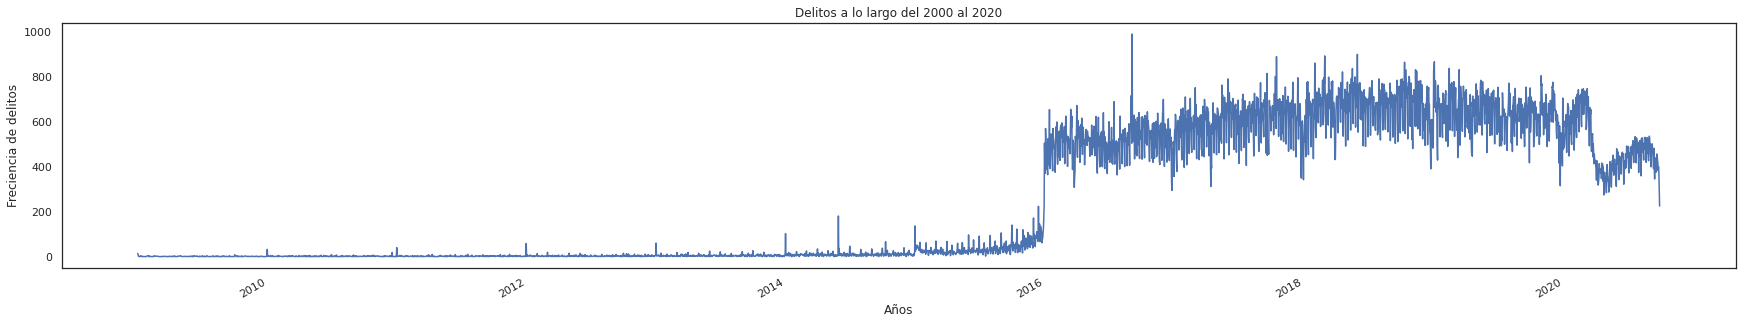

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
serie = cdmx_new.groupby('fecha_hechos')['delito'].count()
serie.plot(figsize = (30,5))
plt.title('Delitos a lo largo del 2000 al 2020')
plt.ylabel('Freciencia de delitos')
plt.xlabel('Años')
plt.show()

[]

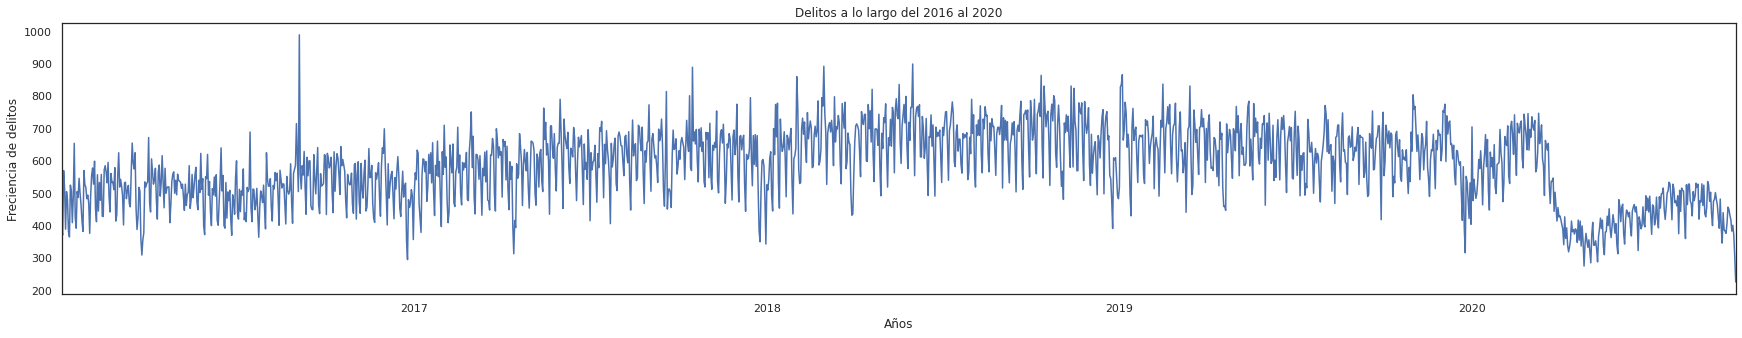

In [ ]:
# Tomamos los datos del 2016 en adelante.
cdmx_2016 = cdmx_new[cdmx_new['fecha_hechos']>datetime(2016,1,1)].groupby('fecha_hechos')['delito'].count()
cdmx_2016.plot(figsize = (30,5))
plt.title('Delitos a lo largo del 2016 al 2020')
plt.ylabel('Freciencia de delitos')
plt.xlabel('Años')
plt.plot()

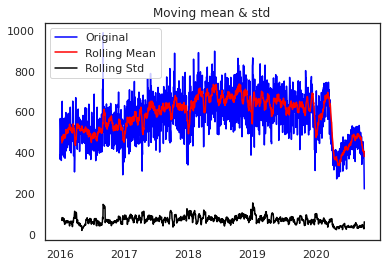

Test Statistic                   -2.291055
p-value                           0.174869
#Lags Used                       22.000000
Number of Observations Used    1711.000000
Critical Value (1%)              -3.434178
Critical Value (5%)              -2.863231
Critical Value (10%)             -2.567670
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

#Determing rolling statistics
rol_mean = cdmx_2016.rolling(12).mean()
rol_std = cdmx_2016.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(cdmx_2016, color='blue',label='Original')
mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Moving mean & std')
plt.show()

# Prueba Dickey-Fuller
test = adfuller(cdmx_2016, autolag='AIC')

dfoutput = pd.Series(test[0:4], index=['Estadístico','p-value','#Lags','num observaciones'])
for key,value in test[4].items():
    dfoutput['Valores criticos (%s)'%key] = value
print(dfoutput)

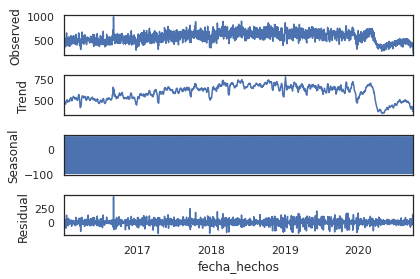

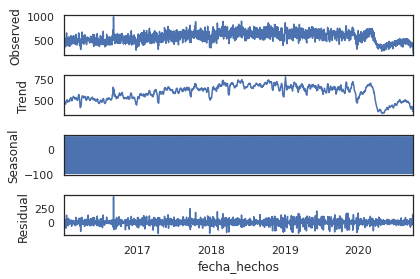

In [ ]:
seasonal_decompose(cdmx_2016, model='additive').plot()

In [ ]:
cdmx_2016

fecha_hechos
2016-01-02    389
2016-01-03    370
2016-01-04    569
2016-01-05    514
2016-01-06    388
             ... 
2020-09-26    382
2020-09-27    400
2020-09-28    371
2020-09-29    303
2020-09-30    225
Name: delito, Length: 1734, dtype: int64

In [ ]:
x = cdmx_2019.groupby('fecha_hechos')['delito'].count().reset_index()
data_week = x['delito'].rolling(window = 30, center = True).mean()

In [ ]:
data_week

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
390   NaN
391   NaN
392   NaN
393   NaN
394   NaN
Name: delito, Length: 395, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(x['delito'])
plt.plot()

In [ ]:
list(map((lambda x:x[0:10]),gdf['fecha_hechos']))

In [ ]:
gdf['fecha_hechos'].apply(lambda x: datetime.strptime(x[0:10],'%Y-%m-%d'))

In [ ]:
path = gdf['categoria_delito'].str.contains('METRO|MICROBUS', regex=True)
robo_trans = gdf[(path)]
robo_trans.reset_index(drop=True)

In [ ]:
metro = geopandas.read_file('/content/drive/My Drive/metro.geojson')
camion = geopandas.read_file('/content/drive/My Drive/camiones.geojson')

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
alcaldias.plot(ax=ax, color='white', edgecolor='black')
metro.plot(ax=ax, color='green')

In [ ]:
def robo_trans(df,type):
  path = df['categoria_delito'].str.contains(type, regex=True)
  robo_trans = df[(path)]
  return robo_trans.reset_index(drop=True)

In [ ]:
metro_rob = robo_trans(gdf,'METRO')
fig, ax = plt.subplots()
ax.set_aspect('equal')
alcaldias.plot(ax=ax, color='white', edgecolor='black')
metro_rob.plot(ax=ax,color='blue',figsize=.0005)
metro.plot(ax=ax, color='green')

In [ ]:
metro_rob

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,geopoint,geometry
0,2017,Febrero,2017-02-01 22:40:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,iztacalco,SANTA ANITA,2017,Febrero,2017-02-02 01:38:47,"19.4042125727,-99.1214213655",POINT (-99.12142 19.40421)
1,2017,Febrero,2017-02-02 09:48:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,cuauhtemoc,CENTRO,2017,Febrero,2017-02-02 11:08:06,"19.4273574478,-99.1490330526",POINT (-99.14903 19.42736)
2,2017,Enero,2017-01-31 20:45:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,cuauhtemoc,JUÁREZ,2017,Febrero,2017-02-02 16:13:27,"19.4298773301,-99.1607495662",POINT (-99.16075 19.42988)
3,2017,Febrero,2017-02-01 19:30:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,miguel hidalgo,TACUBAYA,2017,Febrero,2017-02-03 12:44:52,"19.402052262,-99.186591748",POINT (-99.18659 19.40205)
4,2017,Febrero,2017-02-01 16:30:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,cuauhtemoc,DOCTORES,2017,Febrero,2017-02-03 16:10:43,"19.4268420946,-99.1489374573",POINT (-99.14894 19.42684)
...,...,...,...,...,...,...,...,...,...,...,...,...
10507,2017,Julio,2017-07-25 06:45:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,gustavo a madero,RESIDENCIAL ZACATENCO,2017,Julio,2017-07-25 08:55:57,"19.4952420221,-99.1198103653",POINT (-99.11981 19.49524)
10508,2017,Julio,2017-07-25 09:50:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,miguel hidalgo,TACUBAYA,2017,Julio,2017-07-25 10:45:38,"19.4023274098,-99.188293144",POINT (-99.18829 19.40233)
10509,2017,Julio,2017-07-25 07:00:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,miguel hidalgo,TACUBAYA,2017,Julio,2017-07-25 12:03:40,"19.4019424969,-99.1874663665",POINT (-99.18747 19.40194)
10510,2017,Julio,2017-07-07 12:45:00,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,cuauhtemoc,CENTRO,2017,Julio,2017-07-25 15:38:07,"19.4249399735,-99.1328837648",POINT (-99.13288 19.42494)
